In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, Lasso, Ridge
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm


In [2]:
# config: depends whether you're on Google Colab or local

# On google colab
# Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')
# input_dir = '/content/drive/My Drive/covid19_argentina/data/input/'
# output_dir = '/content/drive/My Drive/covid19_argentina/data/output/'

# Locally
input_dir = './data/input/'
output_dir = './data/output/'



In [3]:
def add_top_column(df, top_col, inplace=True):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [4]:
# Hyperparameter tuning

# Parameters of pipelines can be set using ‘__’ separated parameter names:

def lasso_standardscaler_alpha(X,y,cv=10):
    alphas= np.logspace(-4, 0, 30) #equally spaced on log scale from 10**-4 (0.0004) to 10**0 (1)
    pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()), 
        ('model', Lasso())
    ])
    param_grid = {
        'model__alpha': alphas,
    }
    search = GridSearchCV(pipe,param_grid, cv=cv,n_jobs=-1)
    search.fit(X,y)
    results = pd.DataFrame(search.cv_results_)
    best = results[results['rank_test_score']==1]
    mean_score = best.mean_test_score.values
    std_score = best.std_test_score.values
    alpha = float(best.param_model__alpha.values)
    return alpha

In [5]:
# Load data

df = pd.read_csv(input_dir+'COVID-19_risk.csv', sep = ';')
df

id  Region  Age_scale  Gender  MALE  FEMALE  Educational level SES  \
0       3726       2          1       1     1       0                  2   2   
1      10437       2          1       1     1       0                  2   2   
2      10940       2          1       2     0       1                  3   2   
3      11380       1          1       2     0       1                  1   1   
4      15855       1          1       2     0       1                  1   1   
...      ...     ...        ...     ...   ...     ...                ...  ..   
2889  414511       2          4       1     1       0                  1       
2890  430354       1          4       1     1       0                  2   1   
2891  461092       1          4       1     1       0                  3   3   
2892  471159       1          4       2     0       1                  1       
2893  483619       2          4       1     1       0                  3   2   

      VAC_STATUS  Contagion  Ideology PHQ4_T SANIT_PRES SANIT_FUT RESTRICC  \
0              0          0         0      3          3         4        3   
1              0          0         1      0          3         4        2   
2              0          0         1      7          3         4        3   
3              0          0         0     11          4         5        5   
4              0          1         0                 4         2        3   
...          ...        ...       ...    ...        ...       ...      ...   
2889           0          0         1      1          3         3        3   
2890           0          0         1                 4                  1   
2891           0          0         1      0          3         4        5   
2892           0          0         1                 3                  2   
2893           0          0         1                 2         2        4   

     PHB_INDEX RISK_INDEX  
0                       7  
1           12          6  
2           11          7  
3           12         10  
4           12          7  
...        ...        ...  
2889         9          6  
2890         6             
2891        10          8  
2892         8             
2893         9          8  

[2894 rows x 17 columns]

In [6]:
df.columns

Index(['id', 'Region', 'Age_scale', 'Gender', 'MALE', 'FEMALE',
       'Educational level', 'SES', 'VAC_STATUS', 'Contagion', 'Ideology',
       'PHQ4_T', 'SANIT_PRES', 'SANIT_FUT', 'RESTRICC', 'PHB_INDEX',
       'RISK_INDEX'],
      dtype='object')

In [9]:
# with regards to the correlation, we added a few variables 
X = df[[
        'Region', 'Age_scale', 
#     'Gender', 'MALE', 
    'FEMALE',
       'Educational level', 'SES', 'VAC_STATUS', 'Contagion', 'Ideology',
       'PHQ4_T', 'SANIT_PRES', 'SANIT_FUT', 'RESTRICC', 'PHB_INDEX',
       'RISK_INDEX'
       ]]

# # Create dummy variable for gender
# gender = X['Gender']
# gender = pd.get_dummies(gender,prefix='Gender')
# print(gender)
# print(gender.sum())


# X = X.drop('Gender', axis=1)
# X['Gender_female'] = gender['Gender_1']
# X['Gender_male'] = gender['Gender_2']
# # other genders were not included since there were only 9. 

variables = X.columns.values
clean_names= dict(zip(
    variables,
#     variables
    ['Region', 'Age groups','Female (binary)','Education level','SES', 'Vaccinated',
     'Past Covid19 diagnosis', 'Politically opposed', 'Psychological distress (PHQ4)', 
     'Health Context Appraisal (current)','Health Context Appraisal (future)',
     'Support for restrictions','Protective Health Behaviors Index','Personal Risk Index']
    
    ))

pd.DataFrame(clean_names, index=[0]).T


0
Region                                         Region
Age_scale                                  Age groups
FEMALE                                Female (binary)
Educational level                     Education level
SES                                               SES
VAC_STATUS                                 Vaccinated
Contagion                      Past Covid19 diagnosis
Ideology                          Politically opposed
PHQ4_T                  Psychological distress (PHQ4)
SANIT_PRES         Health Context Appraisal (current)
SANIT_FUT           Health Context Appraisal (future)
RESTRICC                     Support for restrictions
PHB_INDEX           Protective Health Behaviors Index
RISK_INDEX                        Personal Risk Index

In [10]:
X = X.replace(' ', -1)
X = X.astype(float)
X = X.replace(-1, np.nan)


X

Region  Age_scale  FEMALE  Educational level  SES  VAC_STATUS  \
0        2.0        1.0     0.0                2.0  2.0         0.0   
1        2.0        1.0     0.0                2.0  2.0         0.0   
2        2.0        1.0     1.0                3.0  2.0         0.0   
3        1.0        1.0     1.0                1.0  1.0         0.0   
4        1.0        1.0     1.0                1.0  1.0         0.0   
...      ...        ...     ...                ...  ...         ...   
2889     2.0        4.0     0.0                1.0  NaN         0.0   
2890     1.0        4.0     0.0                2.0  1.0         0.0   
2891     1.0        4.0     0.0                3.0  3.0         0.0   
2892     1.0        4.0     1.0                1.0  NaN         0.0   
2893     2.0        4.0     0.0                3.0  2.0         0.0   

      Contagion  Ideology  PHQ4_T  SANIT_PRES  SANIT_FUT  RESTRICC  PHB_INDEX  \
0           0.0       0.0     3.0         3.0        4.0       3.0        NaN   
1           0.0       1.0     0.0         3.0        4.0       2.0       12.0   
2           0.0       1.0     7.0         3.0        4.0       3.0       11.0   
3           0.0       0.0    11.0         4.0        5.0       5.0       12.0   
4           1.0       0.0     NaN         4.0        2.0       3.0       12.0   
...         ...       ...     ...         ...        ...       ...        ...   
2889        0.0       1.0     1.0         3.0        3.0       3.0        9.0   
2890        0.0       1.0     NaN         4.0        NaN       1.0        6.0   
2891        0.0       1.0     0.0         3.0        4.0       5.0       10.0   
2892        0.0       1.0     NaN         3.0        NaN       2.0        8.0   
2893        0.0       1.0     NaN         2.0        2.0       4.0        9.0   

      RISK_INDEX  
0            7.0  
1            6.0  
2            7.0  
3           10.0  
4            7.0  
...          ...  
2889         6.0  
2890         NaN  
2891         8.0  
2892         NaN  
2893         8.0  

[2894 rows x 14 columns]

In [11]:
X.describe()

Region    Age_scale       FEMALE  Educational level          SES  \
count  2894.000000  2894.000000  2894.000000        2894.000000  2601.000000   
mean      1.697650     2.850380     0.575674           2.388390     2.162245   
std       0.459355     0.918417     0.494326           0.728524     0.771495   
min       1.000000     1.000000     0.000000           1.000000     1.000000   
25%       1.000000     2.000000     0.000000           2.000000     2.000000   
50%       2.000000     3.000000     1.000000           3.000000     2.000000   
75%       2.000000     4.000000     1.000000           3.000000     3.000000   
max       2.000000     4.000000     1.000000           3.000000     3.000000   

        VAC_STATUS    Contagion     Ideology       PHQ4_T   SANIT_PRES  \
count  2894.000000  2894.000000  2894.000000  2454.000000  2688.000000   
mean      0.078438     0.066344     0.610919     3.090872     3.047619   
std       0.268906     0.248926     0.487626     3.060388     0.771155   
min       0.000000     0.000000     0.000000     0.000000     1.000000   
25%       0.000000     0.000000     0.000000     0.000000     3.000000   
50%       0.000000     0.000000     1.000000     2.000000     3.000000   
75%       0.000000     0.000000     1.000000     5.000000     4.000000   
max       1.000000     1.000000     1.000000    12.000000     4.000000   

         SANIT_FUT     RESTRICC    PHB_INDEX   RISK_INDEX  
count  2677.000000  2814.000000  2824.000000  2362.000000  
mean      3.854688     3.072139    10.894830     7.934801  
std       1.018600     1.187139     1.493375     2.289319  
min       1.000000     1.000000     3.000000     3.000000  
25%       3.000000     2.000000    10.000000     6.000000  
50%       4.000000     3.000000    11.000000     8.000000  
75%       5.000000     4.000000    12.000000    10.000000  
max       5.000000     5.000000    12.000000    12.000000

In [12]:
X.corr(method='spearman')

Region  Age_scale    FEMALE  Educational level       SES  \
Region             1.000000  -0.111440 -0.005001           0.050861  0.019657   
Age_scale         -0.111440   1.000000  0.041495          -0.085473  0.018993   
FEMALE            -0.005001   0.041495  1.000000           0.042024  0.002793   
Educational level  0.050861  -0.085473  0.042024           1.000000  0.792771   
SES                0.019657   0.018993  0.002793           0.792771  1.000000   
VAC_STATUS        -0.015018   0.135439 -0.014765          -0.000203  0.028594   
Contagion          0.057591  -0.079830 -0.021151          -0.014478 -0.014084   
Ideology           0.044064   0.055173  0.051924           0.069594  0.050626   
PHQ4_T            -0.033845  -0.031138  0.119300          -0.008232 -0.057275   
SANIT_PRES        -0.014786  -0.019493  0.059181          -0.090726 -0.127849   
SANIT_FUT         -0.025615  -0.099869  0.002153           0.048719  0.026661   
RESTRICC          -0.048041  -0.021903  0.012738           0.009216 -0.005245   
PHB_INDEX         -0.123620   0.212779  0.104073          -0.067433 -0.086026   
RISK_INDEX        -0.105752   0.131705  0.067361          -0.010828 -0.020716   

                   VAC_STATUS  Contagion  Ideology    PHQ4_T  SANIT_PRES  \
Region              -0.015018   0.057591  0.044064 -0.033845   -0.014786   
Age_scale            0.135439  -0.079830  0.055173 -0.031138   -0.019493   
FEMALE              -0.014765  -0.021151  0.051924  0.119300    0.059181   
Educational level   -0.000203  -0.014478  0.069594 -0.008232   -0.090726   
SES                  0.028594  -0.014084  0.050626 -0.057275   -0.127849   
VAC_STATUS           1.000000  -0.005474 -0.038695 -0.048086   -0.014551   
Contagion           -0.005474   1.000000 -0.009387  0.008603   -0.001092   
Ideology            -0.038695  -0.009387  1.000000  0.063244    0.061889   
PHQ4_T              -0.048086   0.008603  0.063244  1.000000    0.133230   
SANIT_PRES          -0.014551  -0.001092  0.061889  0.133230    1.000000   
SANIT_FUT           -0.059812   0.000440  0.104539  0.146168    0.376383   
RESTRICC             0.067167  -0.005475 -0.287537  0.025380    0.161294   
PHB_INDEX            0.110725  -0.047997 -0.114109 -0.031114    0.175004   
RISK_INDEX           0.008261  -0.039754 -0.137286  0.238901    0.309539   

                   SANIT_FUT  RESTRICC  PHB_INDEX  RISK_INDEX  
Region             -0.025615 -0.048041  -0.123620   -0.105752  
Age_scale          -0.099869 -0.021903   0.212779    0.131705  
FEMALE              0.002153  0.012738   0.104073    0.067361  
Educational level   0.048719  0.009216  -0.067433   -0.010828  
SES                 0.026661 -0.005245  -0.086026   -0.020716  
VAC_STATUS         -0.059812  0.067167   0.110725    0.008261  
Contagion           0.000440 -0.005475  -0.047997   -0.039754  
Ideology            0.104539 -0.287537  -0.114109   -0.137286  
PHQ4_T              0.146168  0.025380  -0.031114    0.238901  
SANIT_PRES          0.376383  0.161294   0.175004    0.309539  
SANIT_FUT           1.000000  0.135216   0.126879    0.276470  
RESTRICC            0.135216  1.000000   0.173500    0.243314  
PHB_INDEX           0.126879  0.173500   1.000000    0.252865  
RISK_INDEX          0.276470  0.243314   0.252865    1.000000

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentin

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

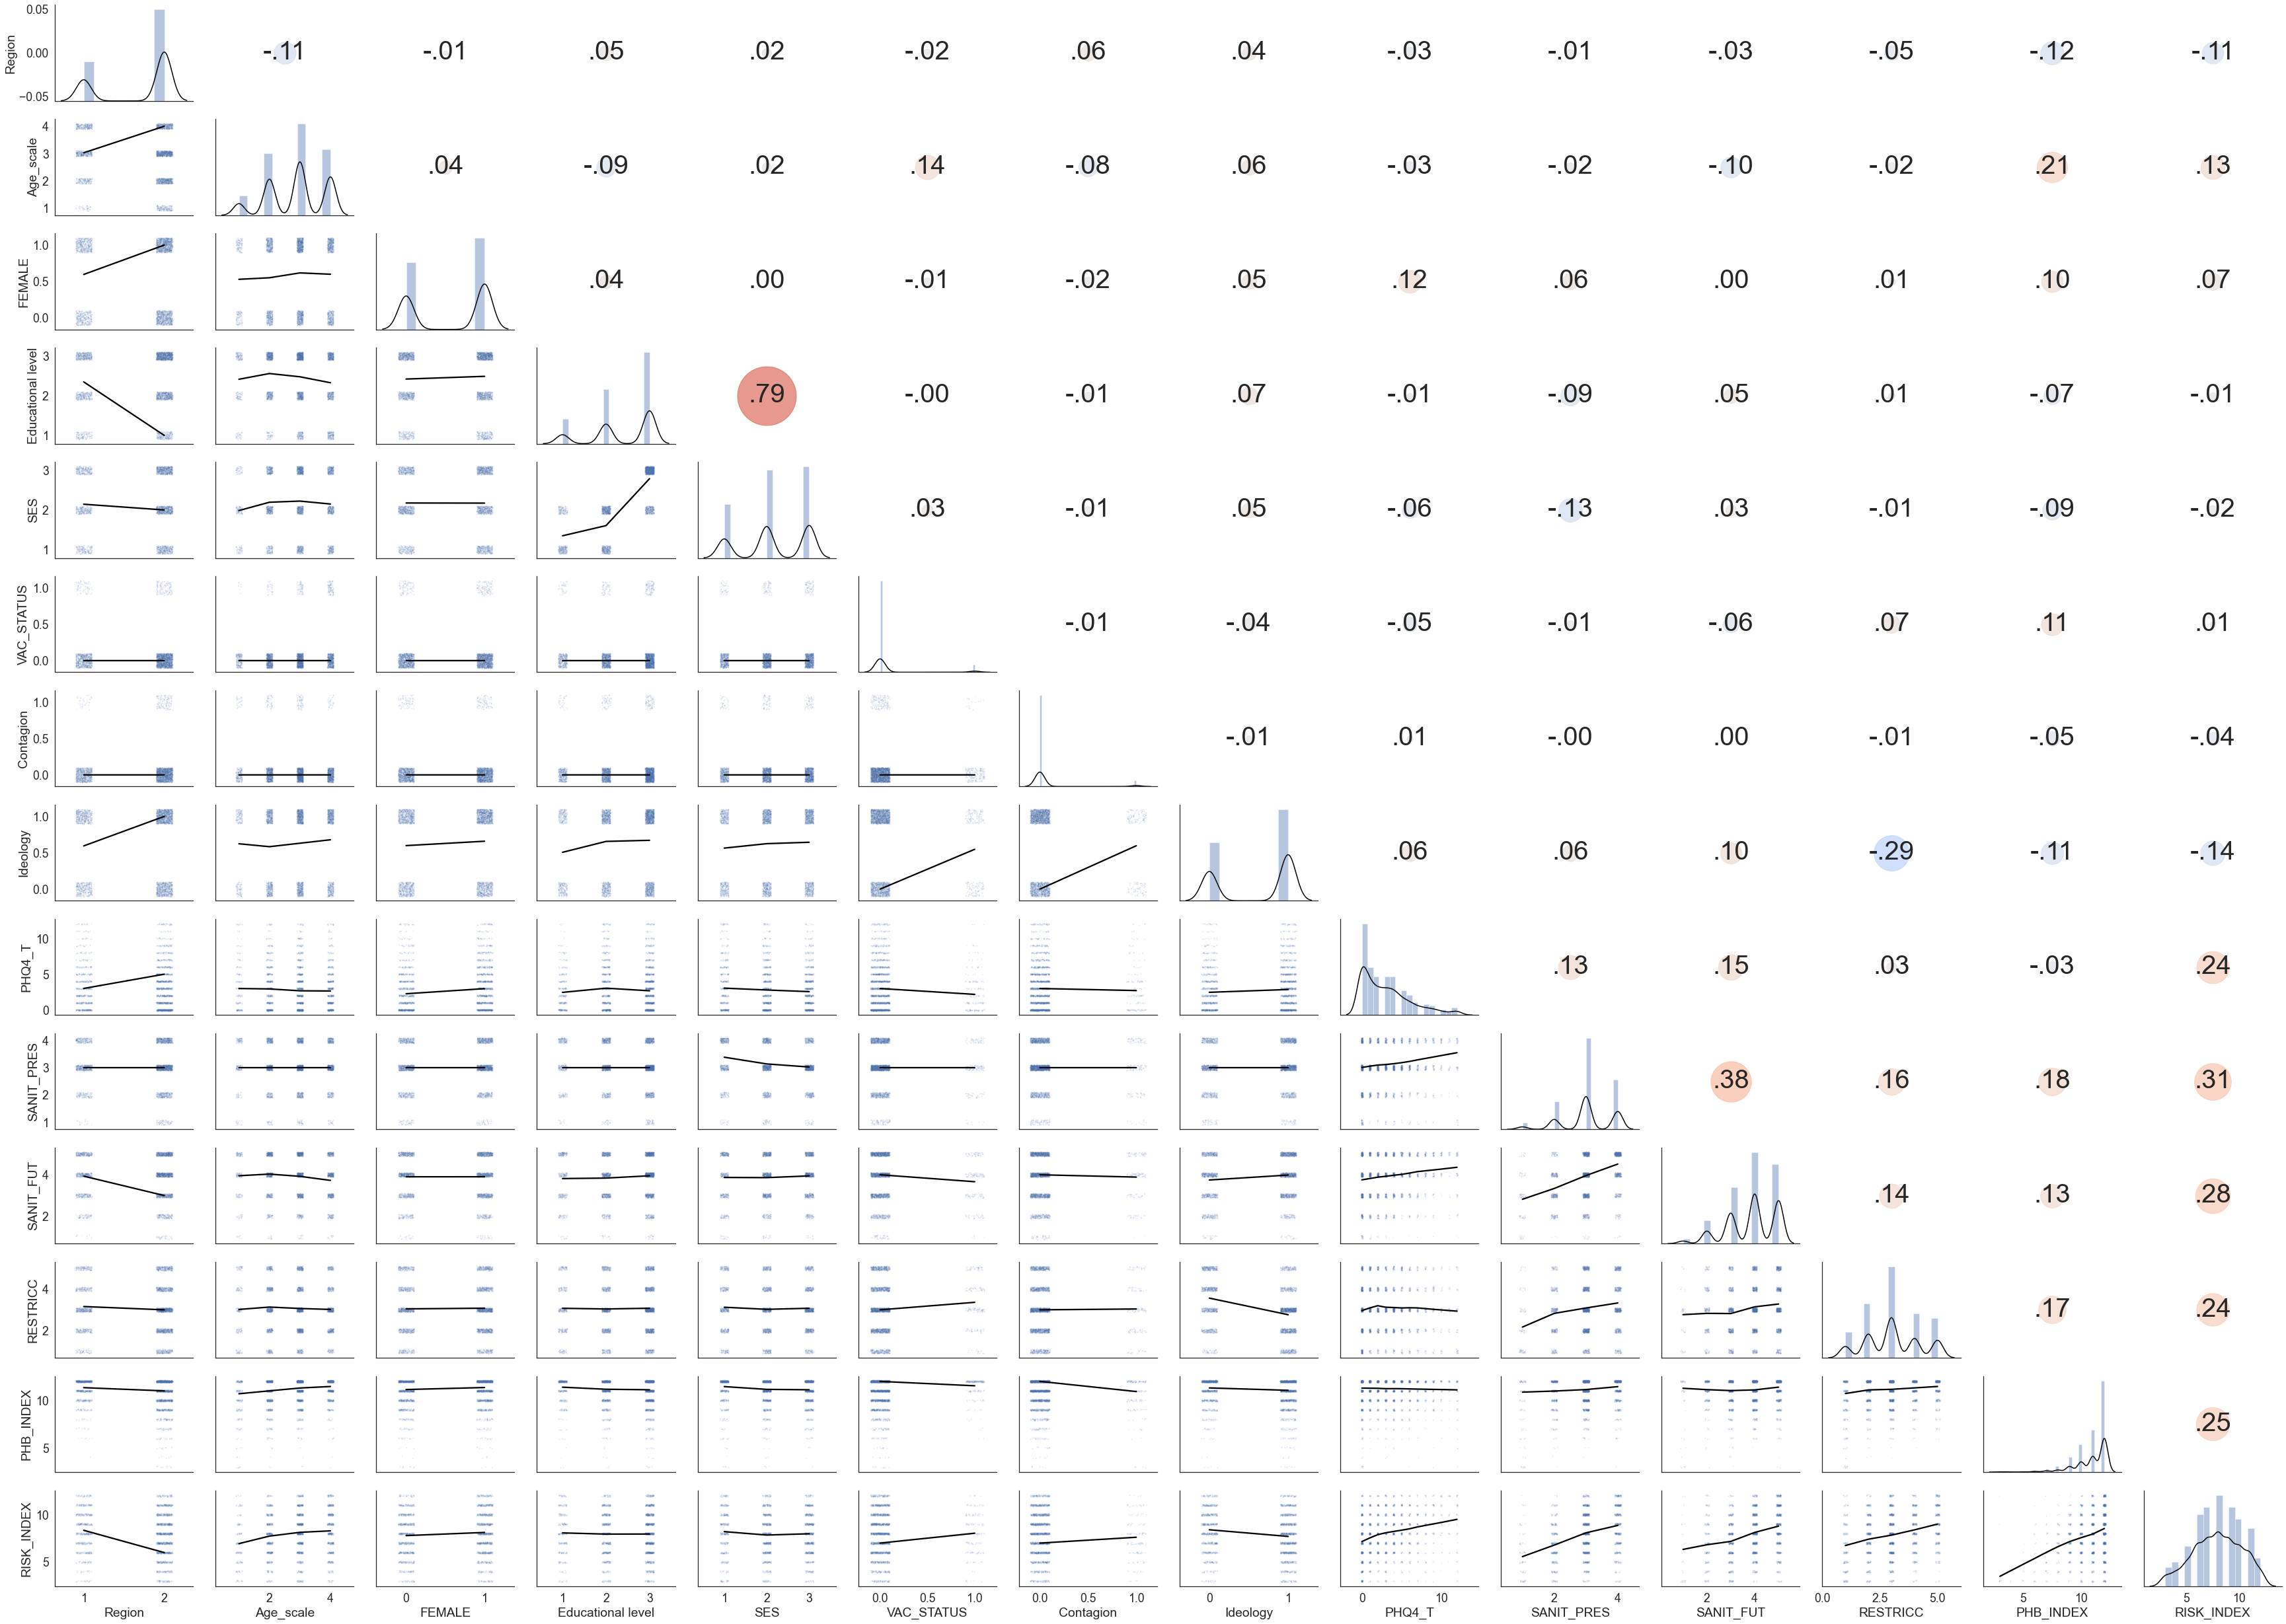

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
#     print(abs(corr_r) *10000)
    
    marker_size = abs(corr_r) * 10000
    
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(X, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'black'}, fit_reg=True,
           x_jitter=.1, y_jitter=.1, 
            scatter_kws={"s": 1, "alpha":0.1},

           
           )
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentin

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

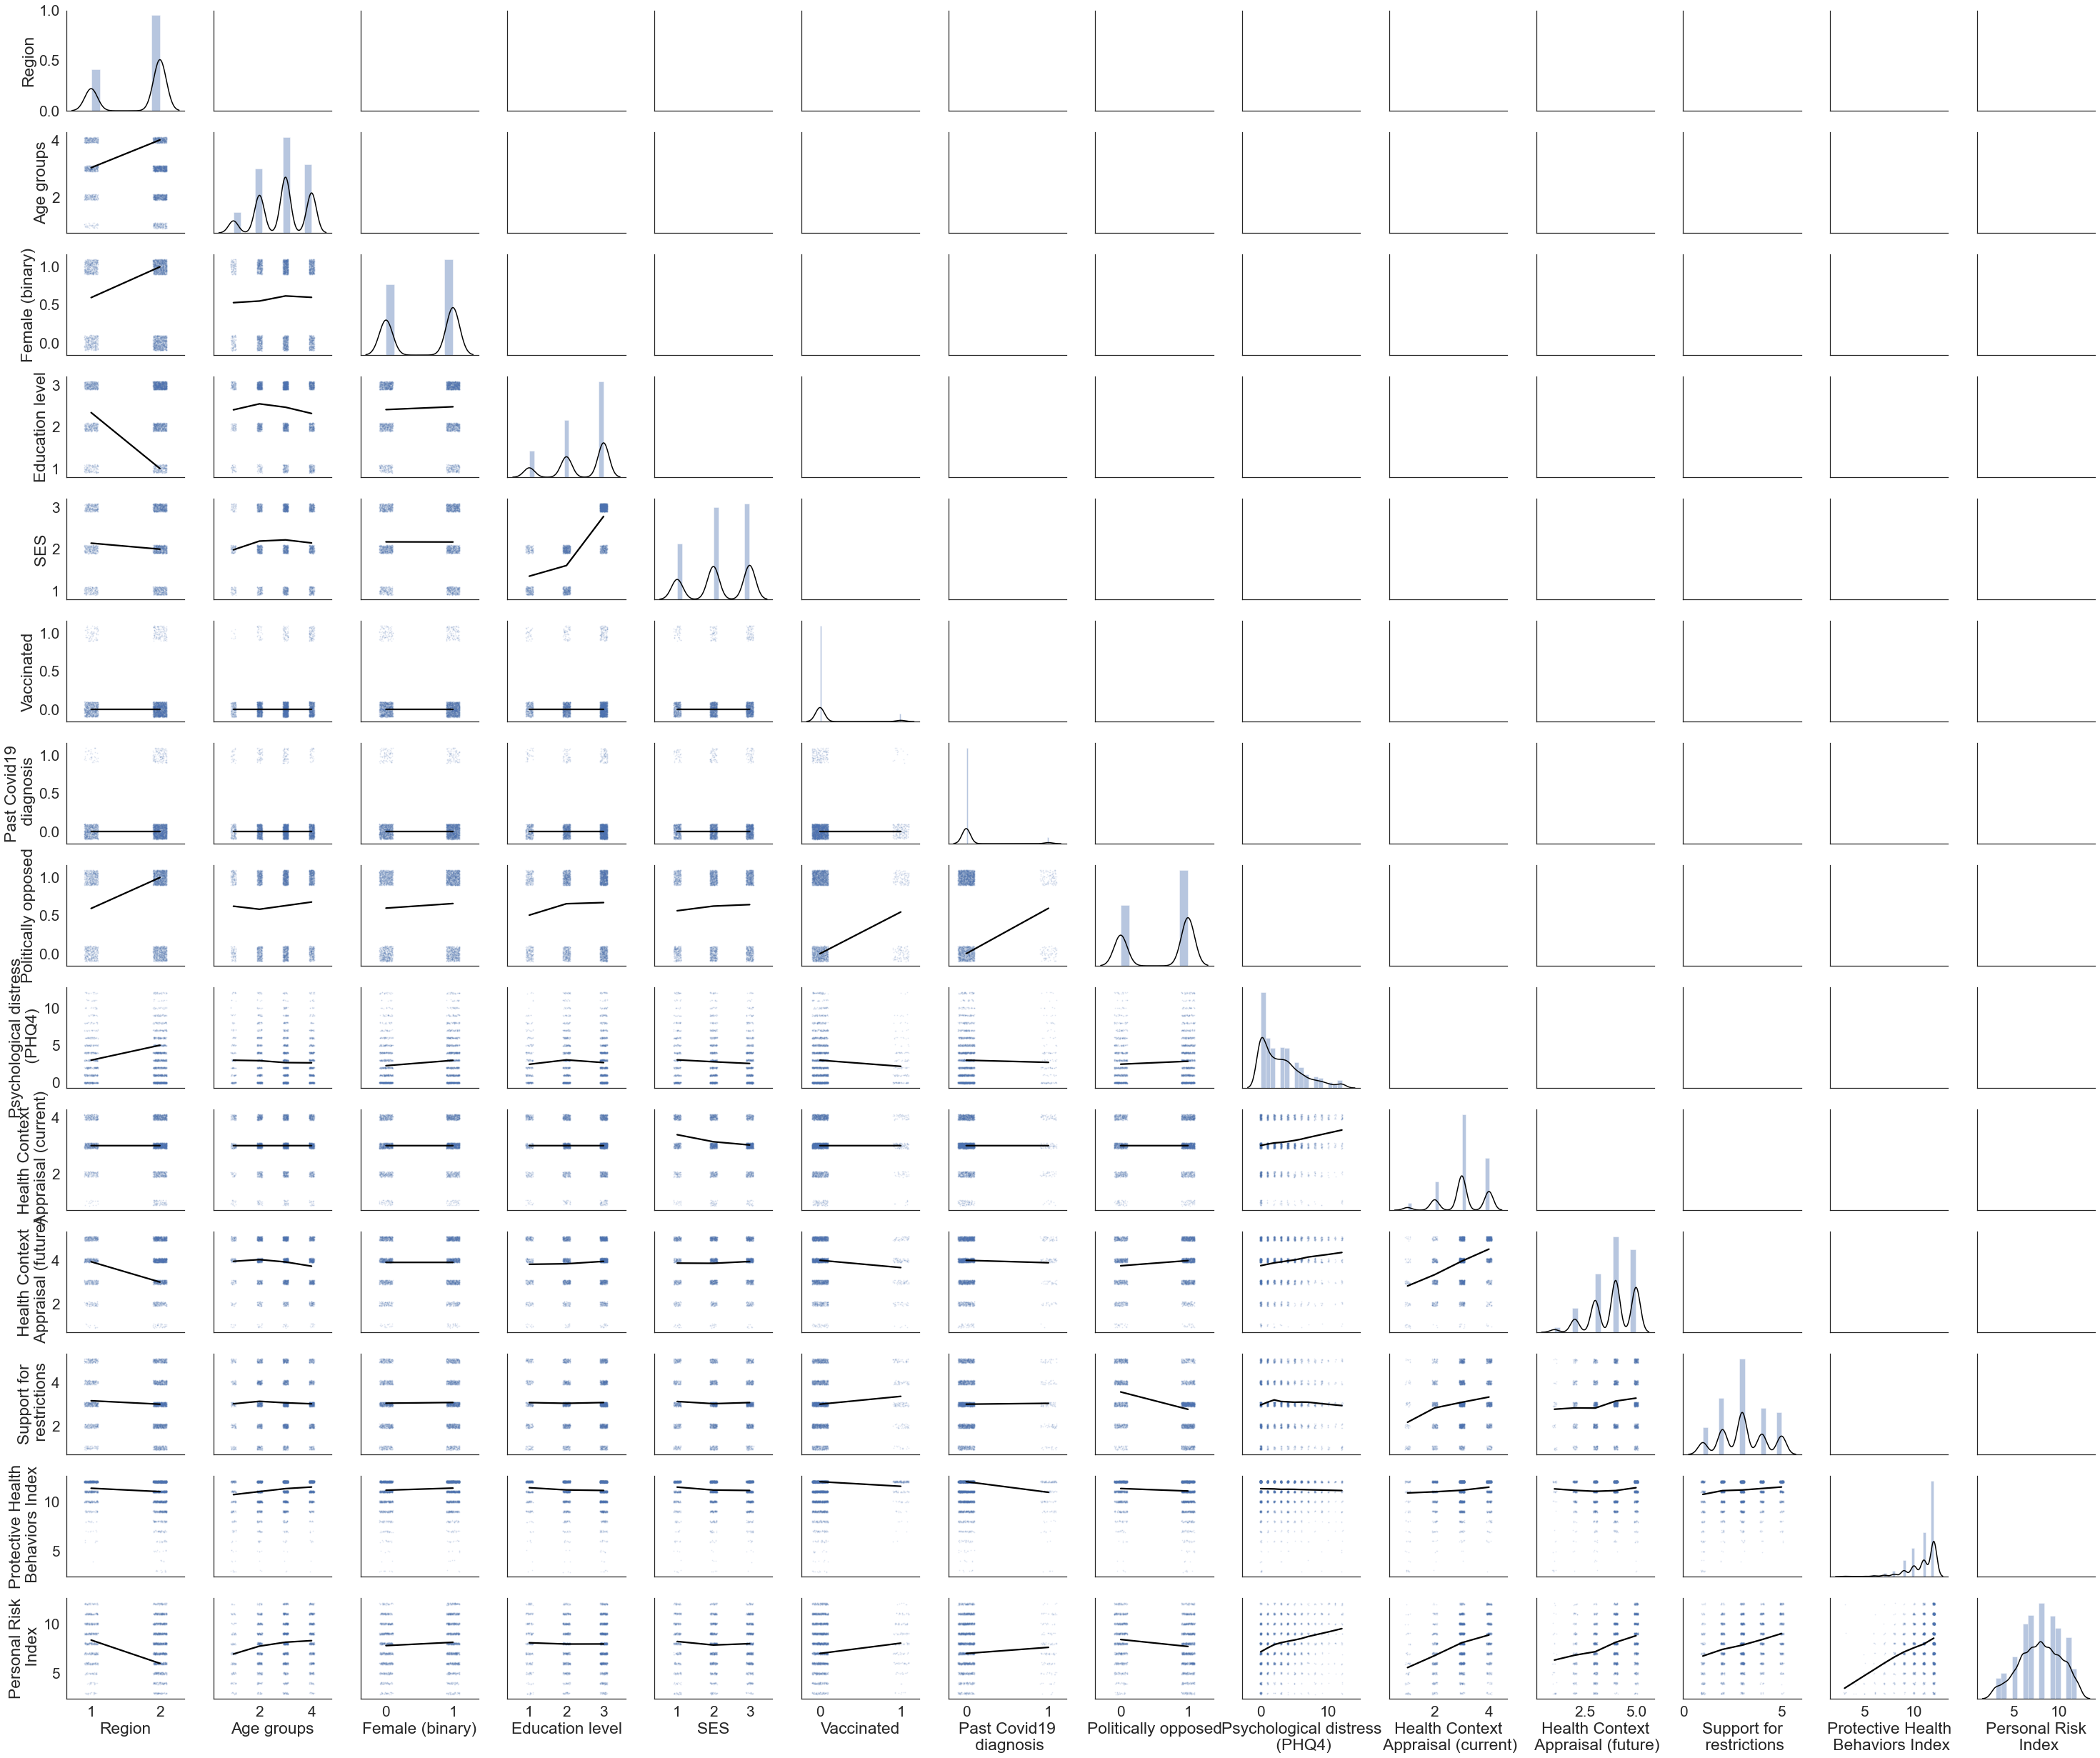

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/danielmlow/miniconda3/envs/covid_argentin

/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/covid_argentina/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

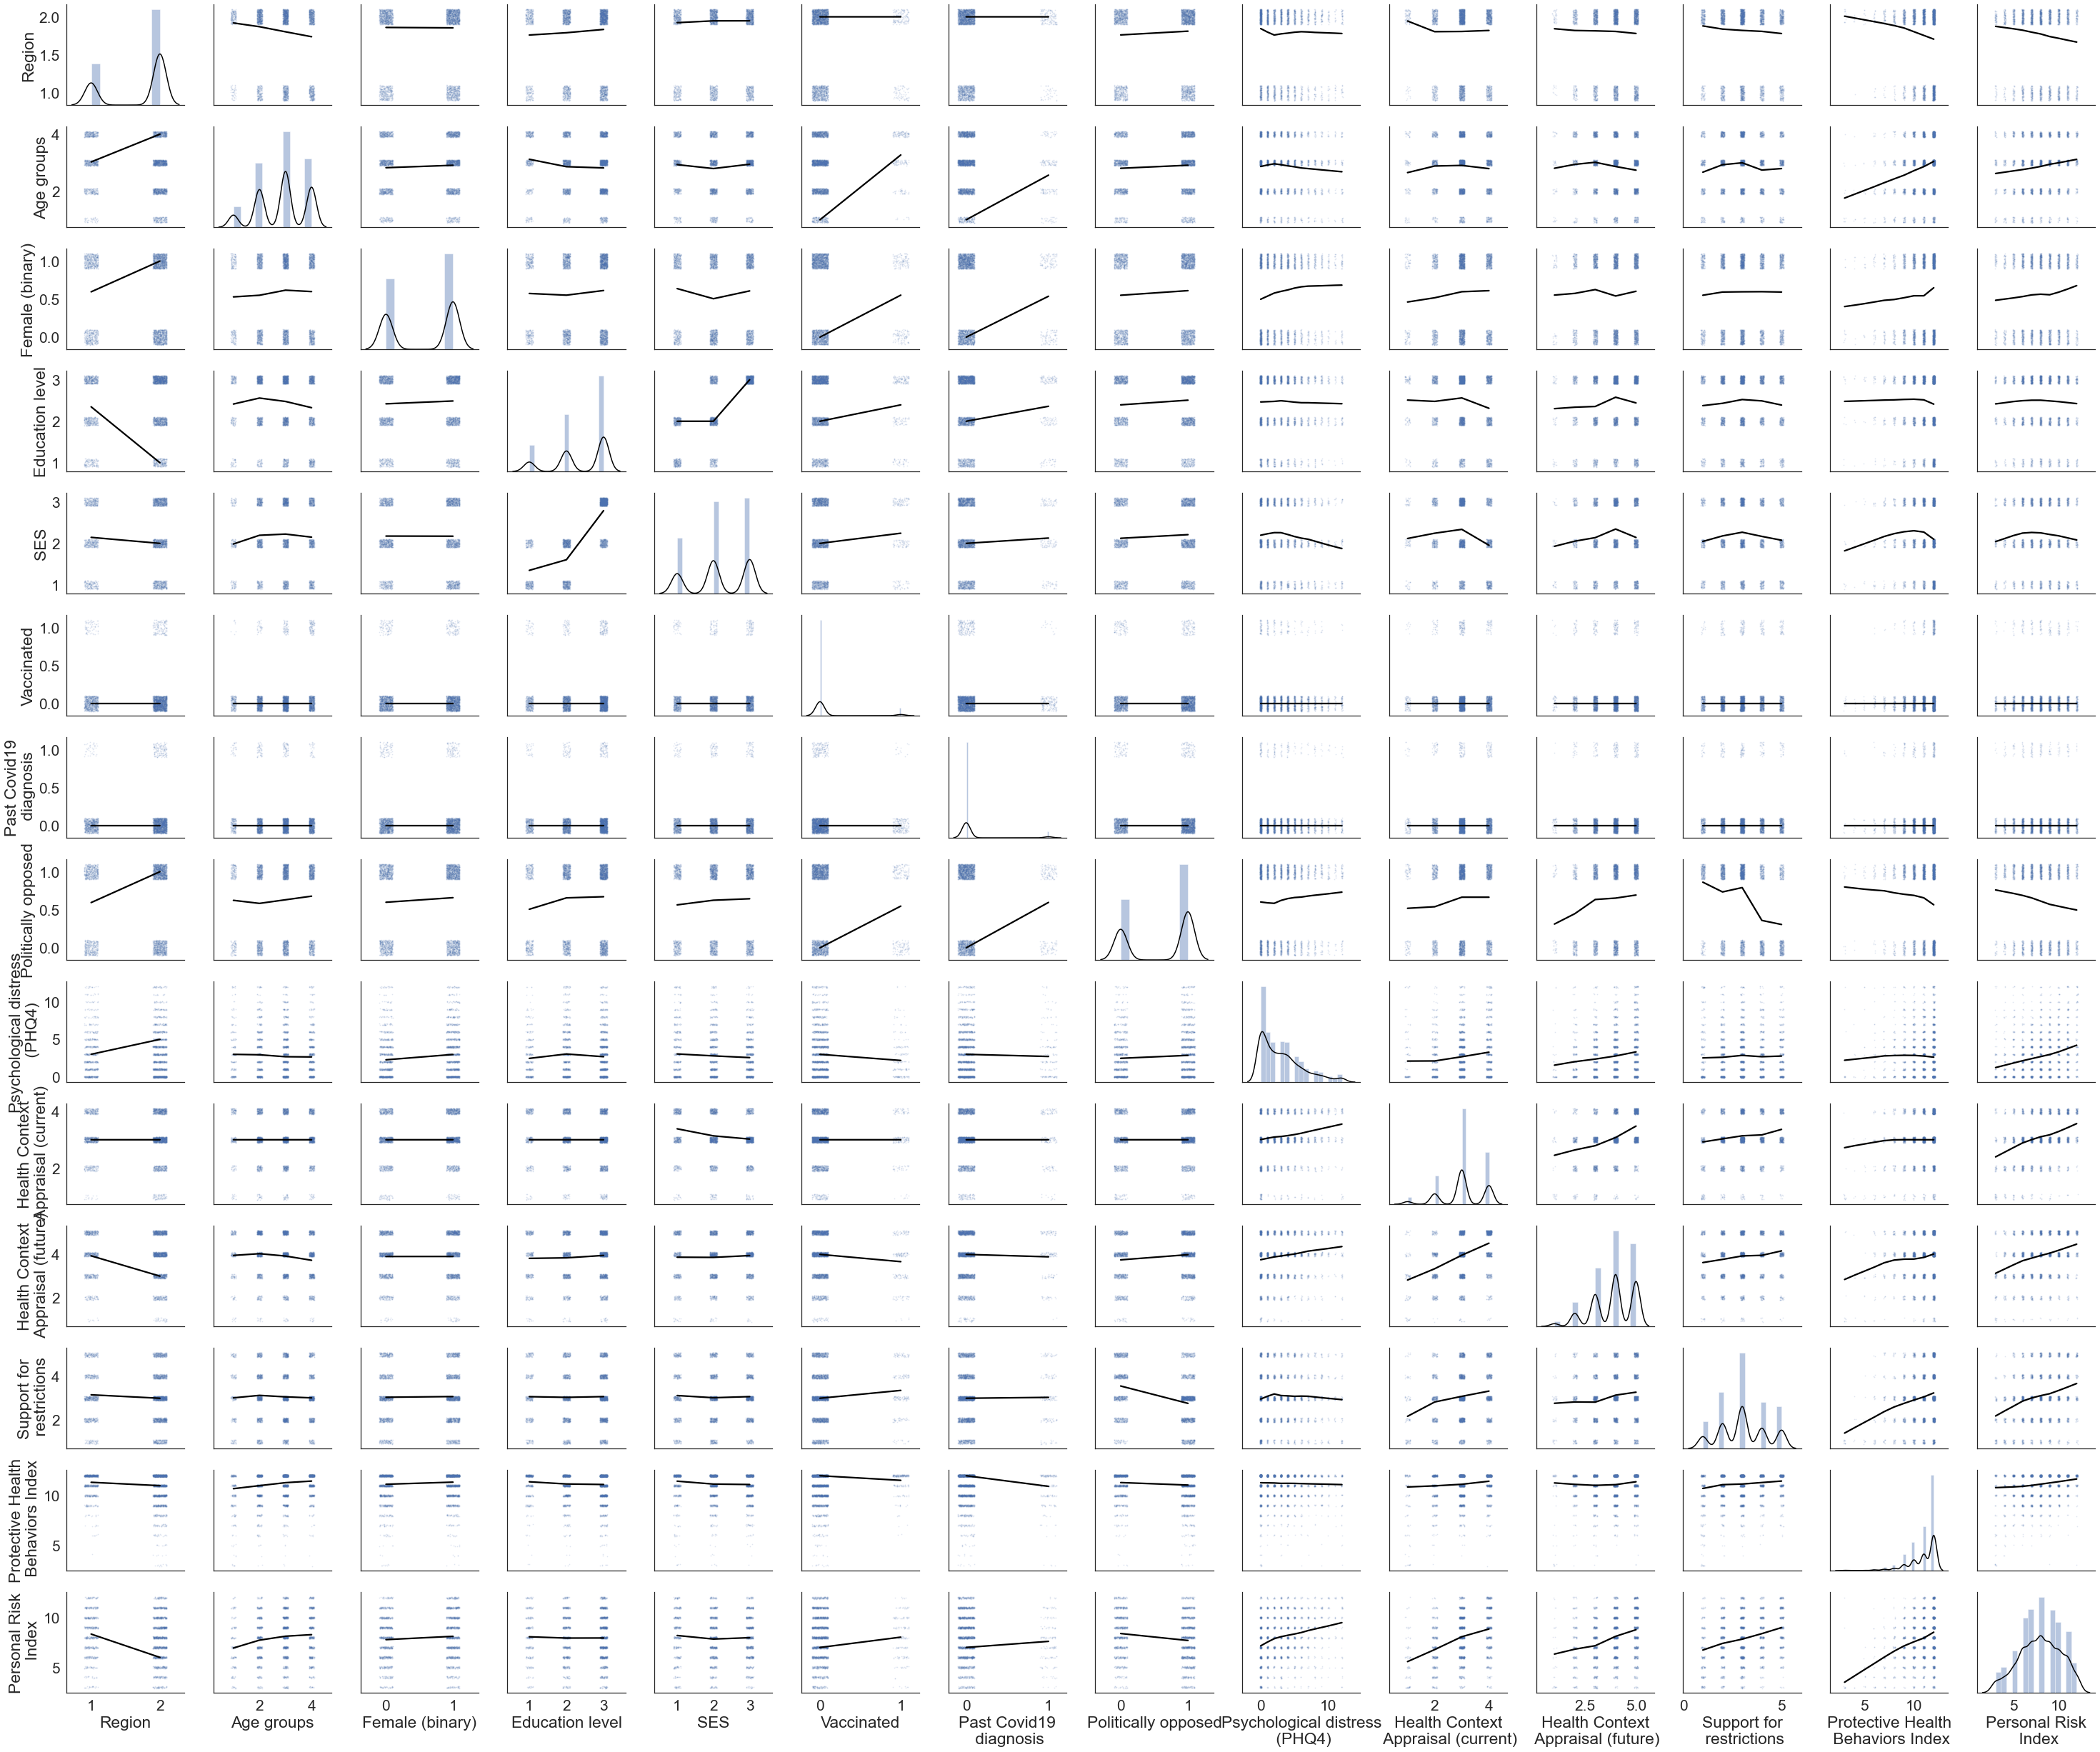

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
#     print(abs(corr_r) *10000)
    
    marker_size = abs(corr_r) * 10000
    
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

    
    
# ======
sns.set(style='white', font_scale=1.9)
# sns.set_context("paper", rc={"axes.labelsize":25})
# iris = sns.load_dataset('iris')
X_clean = X.copy()
col_clean = [clean_names.get(n) for n in X.columns]
col_clean_all = []
for col_name in col_clean:
    words = col_name.split(' ')
    col_name_2_lines = []
    for i, word in enumerate(words):
        if i==1:
            col_name_2_lines.append(word+'\n')
        else:
            col_name_2_lines.append(word)

    col_name_2_lines = ' '.join(col_name_2_lines)
    col_name_2_lines  = col_name_2_lines.strip()
    col_clean_all.append(col_name_2_lines)
        
        

# index = 15
# col_clean = [line[:index] + '\n' + line[index:] for line in col_clean]

for i in ['lower', 'full']:

    X_clean.columns = col_clean_all#col_clean
    g = sns.PairGrid(X_clean, aspect=1.2, diag_sharey=False)

    g.map_lower(sns.regplot, lowess=True, line_kws={'color': 'black'}, fit_reg=True,ci=95, 
               x_jitter=.1, y_jitter=.1, 
                scatter_kws={"s": 1, "alpha":0.1},)
    if i == 'full':
        g.map_upper(sns.regplot, lowess=True, line_kws={'color': 'black'}, fit_reg=True,ci=95, 
                   x_jitter=.1, y_jitter=.1, 
                    scatter_kws={"s": 1, "alpha":0.1},)
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    # g.map_upper(corrdot)




    plt.savefig(output_dir+f'pairwise_scatter_{i}.png', dpi=150)




    plt.show()

In [14]:
# Create DFs for each IV

# Depression

dvs = ['RESTRICC', 'RISK_INDEX', 'PHB_INDEX'] #dependent variables

variable_names = {}
Xs = {}
ys = {}

for dv_i in dvs:
    variable_names[dv_i] = X.drop(dv_i,axis=1).columns.values
    Xs[dv_i] = X.drop(dv_i,axis=1).values
    ys[dv_i] = X[dv_i].values
    print(dv_i, 'covariates', variable_names.get(dv_i))
    print(    Xs.get(dv_i).shape,     ys.get(dv_i).shape)
    print('\n\n')


RESTRICC covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'PHB_INDEX'
 'RISK_INDEX']
(2894, 13) (2894,)



RISK_INDEX covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'RESTRICC'
 'PHB_INDEX']
(2894, 13) (2894,)



PHB_INDEX covariates ['Region' 'Age_scale' 'FEMALE' 'Educational level' 'SES' 'VAC_STATUS'
 'Contagion' 'Ideology' 'PHQ4_T' 'SANIT_PRES' 'SANIT_FUT' 'RESTRICC'
 'RISK_INDEX']
(2894, 13) (2894,)





In [15]:
def pvalues_to_asterisks(pvalues):
    asterisks = []
    for p in pvalues:
        if p<=0.001:
            asterisks.append('***')
        elif p<=0.01:
            asterisks.append('**')
        elif p<=0.05:
            asterisks.append('*')
        elif p>0.05:
            asterisks.append('')
        else:
            print(f'{p} could not be converted, returning empty str')
            asterisks.append('')
            
    return asterisks
            
        

In [77]:
# Train and test


for model in ['lasso', 'ridge']:
    
    coefs_all= []
    r2_all=[]

    for dv_i in dvs:
        dv_name = clean_names.get(dv_i).capitalize()
        print(dv_i, dv_name)
        X_i = Xs.get(dv_i)
        y_i = ys.get(dv_i)
#         imp = SimpleImputer(missing_values=np.nan, strategy='median')
#         y_i = imp.fit_transform(y_i.reshape(-1, 1)) 
        variable_names_i = variable_names.get(dv_i)
    #     X_i = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(X_i.astype(float))
        y_i = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(y_i.reshape(-1, 1))
        X_i = StandardScaler().fit_transform(X_i)
        
        # X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        oos_r2_all = {}
        oos_r2_i = []
        best_alpha_i = []
        for train_index, test_index in sss.split(X_i, y_i):
            X_train, X_test = X_i[train_index], X_i[test_index]
            y_train, y_test = y_i[train_index], y_i[test_index]
            best_alpha = lasso_standardscaler_alpha(X_train,y_train,cv=10) # Find best alpha through CV
            print('best_alpha:',best_alpha)
        #     best_alpha = 0.1
            
            if model == 'lasso':
                model_prediction = Lasso(alpha = best_alpha)
                L1_wt = 1
            elif model == 'ridge':
                model_prediction = Ridge(alpha = best_alpha)
                L1_wt = 0.01
            
            # Train final model      
            pipe = Pipeline(steps=[
                ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                ('scaler', StandardScaler()), 
                ('model', model_prediction)
            ])
            pipe.fit(X_train,y_train)

            # Test with sklearn implementation
            # ========================================================================
            y_pred = pipe.predict(X_test)
            r2 = r2_score(y_test,y_pred)

            oos_r2_i.append(r2)
            best_alpha_i.append(best_alpha)
        oos_r2_i_mean = np.mean(oos_r2_i)
        oos_r2_i_std = np.std(oos_r2_i)
        best_alpha_i_mean = np.mean(best_alpha_i)

        oos_r2_all[dv_name] = [oos_r2_i_mean, oos_r2_i_std]
        print(dv_name, np.round(np.mean(oos_r2_i),2), '+-',np.round(np.std(oos_r2_i),2))
        #     # Obtain standardized beta coefficients     
        #     coefs= pd.DataFrame(pipe['model'].coef_,index=variable_names_i, columns= ['Coefficient'])

        
        # Lasso with statsmodels to obtain p-values
        # =======================================================
        X_i = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(X_i)
        X_i = StandardScaler().fit_transform(X_i)
        X_i = sm.add_constant(X_i, prepend=True)
        iv_names = [clean_names.get(n) for n in X.drop(dv_i,axis=1).columns]
        est = sm.OLS(y_i,X_i).fit_regularized(method = 'elastic_net',alpha=best_alpha_i_mean, L1_wt=L1_wt, 
                                                     refit=True) # if L1_wt=1 it is a lasso fit.
        test_summary = est.summary(xname=['Constant']+list(iv_names))
        print(test_summary)
        dv_name = clean_names.get(dv_i).capitalize()

        
        
        coefs2 = pd.DataFrame(est.params,  index = ['Constant']+list(iv_names), columns = ['Coef.'])
        coefs2['Abs. Coef.'] = coefs2['Coef.'].abs()
        coefs2['P-value'] = pvalues_to_asterisks(est.pvalues)
        coefs2= coefs2.sort_values('Abs. Coef.')[::-1].reset_index()
        coefs2= coefs2.reset_index().round(2)
        coefs2.columns= ['Importance', 'Covariate', 'Coef.','Abs. Coef.', 'P-value']
        coefs2 = coefs2[coefs2.Covariate!='Constant']
        coefs2= coefs2.reset_index(drop=True).round(2)
        coefs2.index +=1 #1-indexed    
        coefs2['Coef.'] =        coefs2['Coef.'].astype(str)   +      coefs2['P-value']
        #     coefs2['Coefficient'] =     coefs2['Coefficient'].astype(str).replace('^(-)0.|^0.',r'\1.',regex=True)
        coefs2= coefs2.drop(['Abs. Coef.','Importance', 'P-value'], axis=1)#drop abs value
        #     r2 = est.rsquared
        coefs2 = add_top_column(coefs2,f'{dv_name}, OOS R2={np.round(oos_r2_i_mean,2)} ({np.round(oos_r2_i_std,2)})' )
        coefs_all.append(coefs2)
        r2_all.append([dv_i,np.round(r2,2)])
        print(coefs2 )
        print('='*100+'\n\n')


    # Concatenate 3 dataframes
    coefs_all_clean = pd.concat(coefs_all,axis=1)
    # coefs_all_clean.index+=1
    coefs_all_clean = coefs_all_clean.rename_axis('Importance').reset_index()
    coefs_all_clean.to_csv(output_dir+f'coefs_all_{model}.csv', index=False)
    print(coefs_all_clean)



RESTRICC Support for restrictions
best_alpha: 0.01610262027560939
best_alpha: 0.01610262027560939
best_alpha: 0.011721022975334805
best_alpha: 0.0032903445623126675
best_alpha: 0.011721022975334805
Support for restrictions 0.15 +- 0.02
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     56.81
Date:                Fri, 27 May 2022   Prob (F-statistic):          3.35e-105
Time:                        18:39:34   Log-Likelihood:                -4301.8
No. Observations:                2894   AIC:                             8626.
Df Residuals:                    2884   BIC:                             8691.
Df Model:                          10                                         
Covariance Type:            nonrobust                

best_alpha: 0.008531678524172805
best_alpha: 0.008531678524172805
best_alpha: 0.006210169418915616
best_alpha: 0.01610262027560939
best_alpha: 0.0032903445623126675
Protective health behaviors index 0.17 +- 0.02
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     43.74
Date:                Fri, 27 May 2022   Prob (F-statistic):          1.02e-109
Time:                        18:39:38   Log-Likelihood:                -4952.3
No. Observations:                2894   AIC:                             9935.
Df Residuals:                    2880   BIC:                         1.002e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                        

best_alpha: 0.011721022975334805
best_alpha: 0.011721022975334805
best_alpha: 0.01610262027560939
best_alpha: 0.01610262027560939
best_alpha: 0.01610262027560939
Personal risk index 0.21 +- 0.03
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     58.40
Date:                Fri, 27 May 2022   Prob (F-statistic):          7.93e-145
Time:                        18:39:42   Log-Likelihood:                -5847.5
No. Observations:                2894   AIC:                         1.172e+04
Df Residuals:                    2880   BIC:                         1.181e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
               

In [78]:
# ridge
coefs_all_clean

Importance Support for restrictions, OOS R2=0.15 (0.02)            \
                                                 Covariate     Coef.   
0           1                          Politically opposed  -0.32***   
1           2                          Personal Risk Index   0.15***   
2           3            Protective Health Behaviors Index   0.14***   
3           4           Health Context Appraisal (current)   0.12***   
4           5            Health Context Appraisal (future)   0.09***   
5           6                                   Vaccinated    0.06**   
6           7                              Education level      0.05   
7           8                                   Age groups    -0.05*   
8           9                Psychological distress (PHQ4)     -0.03   
9          10                                          SES     -0.02   
10         11                                       Region     -0.01   
11         12                       Past Covid19 diagnosis       0.0   
12         13                              Female (binary)       0.0   

   Personal risk index, OOS R2=0.21 (0.03)            \
                                 Covariate     Coef.   
0       Health Context Appraisal (current)   0.38***   
1            Psychological distress (PHQ4)   0.34***   
2        Health Context Appraisal (future)    0.3***   
3        Protective Health Behaviors Index   0.27***   
4                 Support for restrictions   0.25***   
5                      Politically opposed  -0.25***   
6                               Age groups   0.25***   
7                                   Region    -0.08*   
8                          Female (binary)      0.04   
9                          Education level      0.03   
10                              Vaccinated     -0.03   
11                  Past Covid19 diagnosis     -0.03   
12                                     SES      0.01   

   Protective health behaviors index, OOS R2=0.17 (0.01)            
                                               Covariate     Coef.  
0                                          Age groups      0.29***  
1                                 Personal Risk Index      0.21***  
2                  Health Context Appraisal (current)      0.19***  
3                            Support for restrictions      0.17***  
4                                              Region     -0.12***  
5                                     Female (binary)      0.11***  
6                       Psychological distress (PHQ4)      -0.1***  
7                                 Politically opposed      -0.1***  
8                   Health Context Appraisal (future)       0.1***  
9                                          Vaccinated      0.08***  
10                             Past Covid19 diagnosis        -0.04  
11                                                SES        -0.04  
12                                    Education level        -0.01

In [28]:
len(y_train), len(y_test)

(2315, 579)